In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [59]:
# data loading
df = pd.read_csv('filtered_data_mimed0101(1).csv')
df.head()

,Type,adjusted_time_ints,adjusted_time,Price,Volume
0,ask,0.0,0 days 00:00:00,258.684211,2.0
1,ask,1.0,0 days 00:01:00,254.000000,5.0
2,ask,2.0,0 days 00:02:00,258.000000,1.0
3,ask,3.0,0 days 00:03:00,259.000000,4.0
4,ask,4.0,0 days 00:04:00,261.000000,2.0


In [60]:
df_ask = df[df['Type'] == 'ask']
df_ask.reset_index(drop=True, inplace=True)
df_bid = df[df['Type'] == 'bid']
df_bid.reset_index(drop=True, inplace=True)

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [62]:
# set seed
torch.manual_seed(42)

# min-max normalization
scaler_ask = MinMaxScaler()
df_normalized_ask = pd.DataFrame(scaler_ask.fit_transform(df_ask[['Price']]), columns=['Price'])

scaler_bid = MinMaxScaler()
df_normalized_bid = pd.DataFrame(scaler_bid.fit_transform(df_bid[['Price']]), columns=['Price'])

# convert to tensor
tensor_data_ask = torch.FloatTensor(df_normalized_ask.values)
tensor_data_bid = torch.FloatTensor(df_normalized_bid.values)

# create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# setting hyperparameters
input_size = 1  
hidden_size = 64
output_size = 1  
seq_length = 60  

# create sequences
sequences_ask, labels_ask = create_sequences(tensor_data_ask, seq_length)
sequences_bid, labels_bid = create_sequences(tensor_data_bid, seq_length)

# split data
train_size_ask = int(len(sequences_ask) * 0.80)
test_size_ask = len(sequences_ask) - train_size_ask
train_sequences_ask, test_sequences_ask = sequences_ask[:train_size_ask], sequences_ask[train_size_ask:]
train_labels_ask, test_labels_ask = labels_ask[:train_size_ask], labels_ask[train_size_ask:]

train_size_bid = int(len(sequences_bid) * 0.80)
test_size_bid = len(sequences_bid) - train_size_bid
train_sequences_bid, test_sequences_bid = sequences_bid[:train_size_bid], sequences_bid[train_size_bid:]
train_labels_bid, test_labels_bid = labels_bid[:train_size_bid], labels_bid[train_size_bid:]

# create data loader
train_dataset_ask = TensorDataset(train_sequences_ask, train_labels_ask)
test_dataset_ask = TensorDataset(test_sequences_ask, test_labels_ask)

train_loader_ask = DataLoader(train_dataset_ask, batch_size=64, shuffle=True)
test_loader_ask = DataLoader(test_dataset_ask, batch_size=64, shuffle=False)


train_dataset_bid = TensorDataset(train_sequences_bid, train_labels_bid)
test_dataset_bid = TensorDataset(test_sequences_bid, test_labels_bid)

train_loader_bid = DataLoader(train_dataset_bid, batch_size=64, shuffle=True)
test_loader_bid = DataLoader(test_dataset_bid, batch_size=64, shuffle=False)

In [63]:
# define model
class GRU(nn.Module):
    # define model
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRU, self).__init__()
        # hidden dimensions
        self.hidden_size = hidden_size
        # number of hidden layers
        self.num_layers = num_layers

        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # define the forward propagation function
    def forward(self, x):

        # initialize hidden state with zeros
        hn = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        hn = hn.to(device)
        out, _ = self.rnn(x,hn)

        out = self.fc(out[:, -1, :])

        return out


# define evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    # without computing gradients
    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            # forward pass
            outputs = model(batch_sequences)
            loss = criterion(outputs.squeeze(), batch_labels.squeeze())
            # collect results
            all_labels.extend(batch_labels.cpu().numpy().flatten())
            all_predictions.extend(outputs.cpu().numpy().flatten())

            # compute loss
            test_loss += loss.item()

    # calculate average loss
    average_test_loss = test_loss / len(test_loader)

    # calculate metrics
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = sqrt(mse)

    return average_test_loss, mae, mse, rmse,all_labels,all_predictions

In [64]:
# create model
model_ask = GRU(input_size, hidden_size, output_size, num_layers=1, dropout=0.2).to(device)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer_ask = optim.Adam(model_ask.parameters(), lr=0.001)

# create dataframe to save results
df_results = pd.DataFrame(columns=['Epoch', 'Train Loss','Test Loss', 'Test MAE', 'Test MSE', 'Test RMSE'])

# train model
num_epochs = 50

for epoch in range(num_epochs):
    
    model_ask.train()
    for batch_sequences, batch_labels in train_loader_ask:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        optimizer_ask.zero_grad()
        outputs = model_ask(batch_sequences)

        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        optimizer_ask.step()

    # evaluate model
    test_loss, test_mae, test_mse, test_rmse,test_label,predicted_labels = evaluate_model(model_ask, test_loader_ask, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {loss.item():.6f}, Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}')
    # save results
    df_results.loc[len(df_results)] = [epoch+1, loss.item(), test_loss, test_mae, test_mse, test_rmse]

Epoch [1/50],Train Loss: 0.000214, Test Loss: 0.000491, Test MAE: 0.0175, Test MSE: 0.0175, Test RMSE: 0.0222
Epoch [2/50],Train Loss: 0.000468, Test Loss: 0.000419, Test MAE: 0.0175, Test MSE: 0.0175, Test RMSE: 0.0205
Epoch [3/50],Train Loss: 0.000228, Test Loss: 0.000414, Test MAE: 0.0175, Test MSE: 0.0175, Test RMSE: 0.0204
Epoch [4/50],Train Loss: 0.000275, Test Loss: 0.000550, Test MAE: 0.0178, Test MSE: 0.0178, Test RMSE: 0.0235
Epoch [5/50],Train Loss: 0.000483, Test Loss: 0.000559, Test MAE: 0.0179, Test MSE: 0.0179, Test RMSE: 0.0236
Epoch [6/50],Train Loss: 0.000420, Test Loss: 0.000439, Test MAE: 0.0172, Test MSE: 0.0172, Test RMSE: 0.0209
Epoch [7/50],Train Loss: 0.000527, Test Loss: 0.000526, Test MAE: 0.0176, Test MSE: 0.0176, Test RMSE: 0.0229
Epoch [8/50],Train Loss: 0.000544, Test Loss: 0.000413, Test MAE: 0.0174, Test MSE: 0.0174, Test RMSE: 0.0203
Epoch [9/50],Train Loss: 0.000452, Test Loss: 0.000470, Test MAE: 0.0172, Test MSE: 0.0172, Test RMSE: 0.0217
Epoch [10/

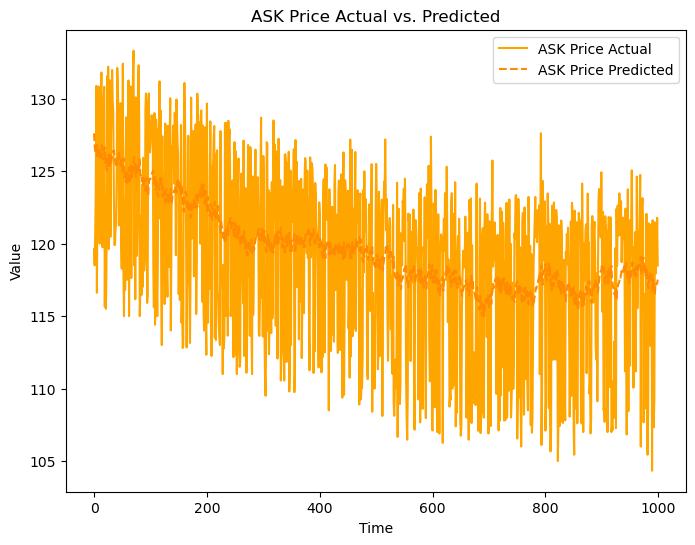

In [65]:
import matplotlib.pyplot as plt

# plot the comparison
plt.figure(figsize=(8, 6))

test_label = scaler_ask.inverse_transform(test_labels_ask.cpu().numpy().flatten().reshape(-1, 1))
predicted_labels_ = scaler_ask.inverse_transform(np.array(predicted_labels).reshape(-1, 1))

plt.plot(test_label[:1000], color='orange', label='ASK Price Actual')
plt.plot(predicted_labels_[:1000], linestyle='dashed', color='darkorange', label='ASK Price Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('ASK Price Actual vs. Predicted')
plt.show()


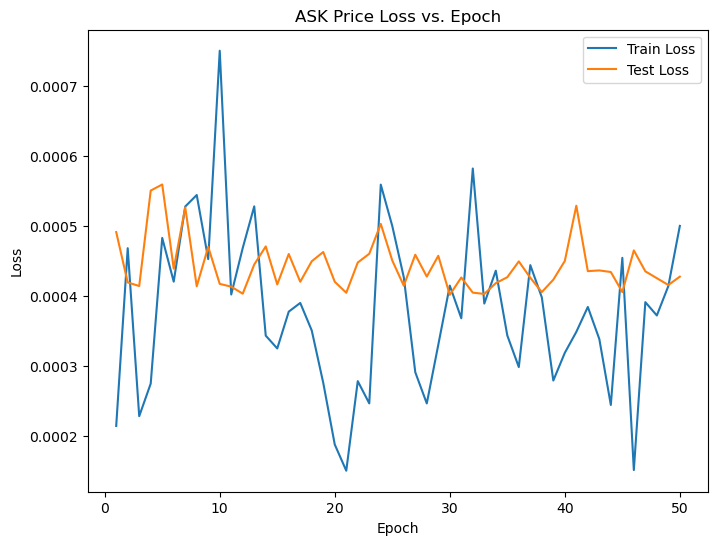

In [66]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Train Loss'].values, label='Train Loss')
plt.plot(df_results['Epoch'].values, df_results['Test Loss'].values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ASK Price Loss vs. Epoch')
plt.show()


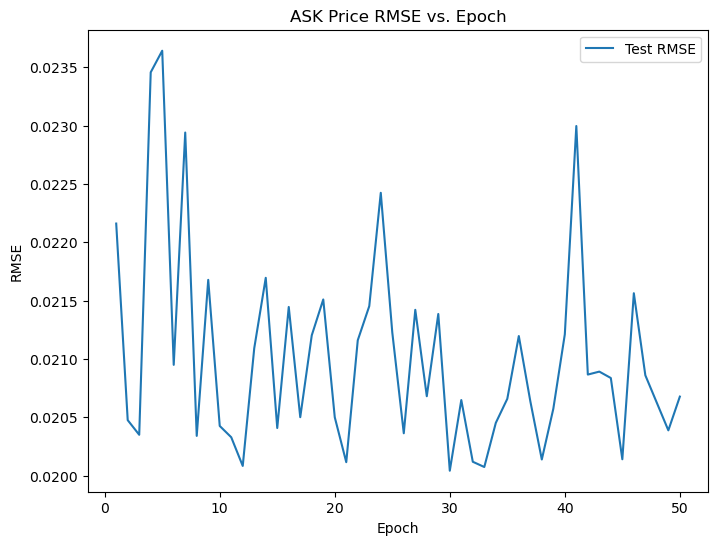

In [67]:
# plot RMSE
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Test RMSE'].values, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('ASK Price RMSE vs. Epoch')
plt.show()

In [68]:
# create model
model_bid = GRU(input_size, hidden_size, output_size, num_layers=1, dropout=0.2).to(device)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer_bid = optim.Adam(model_bid.parameters(), lr=0.001)

# create dataframe to save results
df_results = pd.DataFrame(columns=['Epoch', 'Train Loss','Test Loss', 'Test MAE', 'Test MSE', 'Test RMSE'])

# train model
num_epochs = 50

for epoch in range(num_epochs):
    
    model_bid.train()
    for batch_sequences, batch_labels in train_loader_bid:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        optimizer_bid.zero_grad()
        outputs = model_bid(batch_sequences)

        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        optimizer_bid.step()

    # evaluate model
    test_loss, test_mae, test_mse, test_rmse,test_label,predicted_labels = evaluate_model(model_bid, test_loader_bid, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {loss.item():.6f}, Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}')
    # save results
    df_results.loc[len(df_results)] = [epoch+1, loss.item(), test_loss, test_mae, test_mse, test_rmse]

Epoch [1/50],Train Loss: 0.000040, Test Loss: 0.000054, Test MAE: 0.0070, Test MSE: 0.0070, Test RMSE: 0.0073
Epoch [2/50],Train Loss: 0.000010, Test Loss: 0.000025, Test MAE: 0.0047, Test MSE: 0.0047, Test RMSE: 0.0050
Epoch [3/50],Train Loss: 0.000049, Test Loss: 0.000027, Test MAE: 0.0049, Test MSE: 0.0049, Test RMSE: 0.0052
Epoch [4/50],Train Loss: 0.000003, Test Loss: 0.000020, Test MAE: 0.0041, Test MSE: 0.0041, Test RMSE: 0.0045
Epoch [5/50],Train Loss: 0.000010, Test Loss: 0.000004, Test MAE: 0.0013, Test MSE: 0.0013, Test RMSE: 0.0019
Epoch [6/50],Train Loss: 0.000024, Test Loss: 0.000026, Test MAE: 0.0047, Test MSE: 0.0047, Test RMSE: 0.0051
Epoch [7/50],Train Loss: 0.000014, Test Loss: 0.000006, Test MAE: 0.0020, Test MSE: 0.0020, Test RMSE: 0.0025
Epoch [8/50],Train Loss: 0.000051, Test Loss: 0.000004, Test MAE: 0.0013, Test MSE: 0.0013, Test RMSE: 0.0020
Epoch [9/50],Train Loss: 0.000016, Test Loss: 0.000004, Test MAE: 0.0014, Test MSE: 0.0014, Test RMSE: 0.0021
Epoch [10/

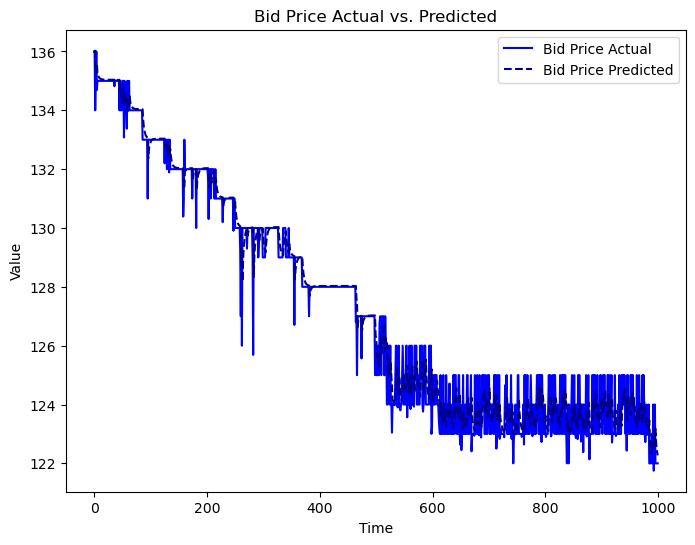

In [69]:
import matplotlib.pyplot as plt

# plot the comparison
plt.figure(figsize=(8, 6))

test_label = scaler_bid.inverse_transform(test_labels_bid.cpu().numpy().flatten().reshape(-1, 1))
predicted_labels_ = scaler_bid.inverse_transform(np.array(predicted_labels).reshape(-1, 1))

plt.plot(test_label[:1000], color='blue', label='Bid Price Actual')
plt.plot(predicted_labels_[:1000], linestyle='dashed', color='darkblue', label='Bid Price Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Bid Price Actual vs. Predicted')
plt.show()


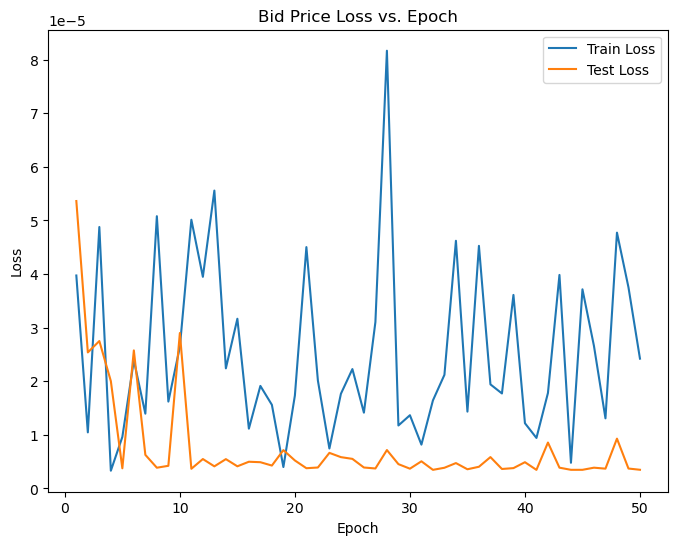

In [70]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Train Loss'].values, label='Train Loss')
plt.plot(df_results['Epoch'].values, df_results['Test Loss'].values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Bid Price Loss vs. Epoch')
plt.show()


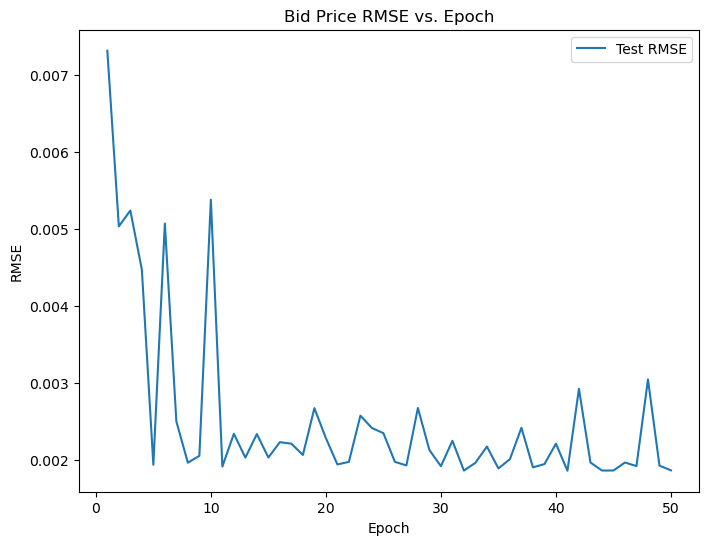

In [71]:
# plot RMSE
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Test RMSE'].values, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Bid Price RMSE vs. Epoch')
plt.show()